In [24]:
!pip install shap scikit-learn pandas -q
# =======================
# Imports
# =======================
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import datetime


In [25]:

#  Dataset Collection & Preprocessing


# Load Heart Disease dataset
heart_data = fetch_openml(name='heart-disease', version=1, as_frame=True)

# Work with full df to ensure we have both features + target
df = heart_data.frame.copy()

# Extract target (already numeric in this dataset)
if 'target' in df.columns:
    y = df['target'].fillna(0).astype(int)  # target: 1 = disease, 0 = no disease
    X = df.drop(columns=['target'])
else:
    raise ValueError("Target column 'target' not found in dataset")

print("Dataset shape:", X.shape)
print("Target distribution:\n", y.value_counts())

# Ensure 'sex' column exists and is integer: 1 = Male, 0 = Female
if 'sex' not in X.columns:
    raise ValueError("'sex' column not found in dataset")
X['sex'] = pd.to_numeric(X['sex'], errors='coerce').fillna(0).astype(int)
print("Unique values in 'sex':", X['sex'].unique())


Dataset shape: (303, 13)
Target distribution:
 target
1    165
0    138
Name: count, dtype: int64
Unique values in 'sex': [1 0]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (212, 13) Test shape: (91, 13)


In [28]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

In [29]:

#  Model Evaluation
# =======================
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Initial audit log entry
audit_log = {
    "timestamp": datetime.datetime.now().isoformat(),
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}
print("\nAudit Log Initial Entry:\n", audit_log)



Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        41
           1       0.84      0.84      0.84        50

    accuracy                           0.82        91
   macro avg       0.82      0.82      0.82        91
weighted avg       0.82      0.82      0.82        91


Audit Log Initial Entry:
 {'timestamp': '2025-08-14T08:52:54.178375', 'classification_report': {'0': {'precision': 0.8048780487804879, 'recall': 0.8048780487804879, 'f1-score': 0.8048780487804879, 'support': 41.0}, '1': {'precision': 0.84, 'recall': 0.84, 'f1-score': 0.84, 'support': 50.0}, 'accuracy': 0.8241758241758241, 'macro avg': {'precision': 0.822439024390244, 'recall': 0.822439024390244, 'f1-score': 0.822439024390244, 'support': 91.0}, 'weighted avg': {'precision': 0.8241758241758241, 'recall': 0.8241758241758241, 'f1-score': 0.8241758241758241, 'support': 91.0}}, 'confusion_matrix': [[33, 8], [8, 42]]}


In [30]:
#  Bias Detection by Sex
# =======================
test_results = X_test.copy()
test_results['actual'] = y_test.values
test_results['predicted'] = y_pred

grouped = test_results.groupby('sex').agg(
    total=('actual', 'count'),
    positive_rate_actual=('actual', 'mean'),
    positive_rate_predicted=('predicted', 'mean')
)
grouped.index = grouped.index.map({0: 'Female', 1: 'Male'})
print("\nOutcome rates by Sex:\n", grouped)

# Add bias report to audit log
bias_report = grouped.to_string()
audit_log['bias_report'] = bias_report



Outcome rates by Sex:
         total  positive_rate_actual  positive_rate_predicted
sex                                                         
Female     24              0.750000                 0.750000
Male       67              0.477612                 0.477612


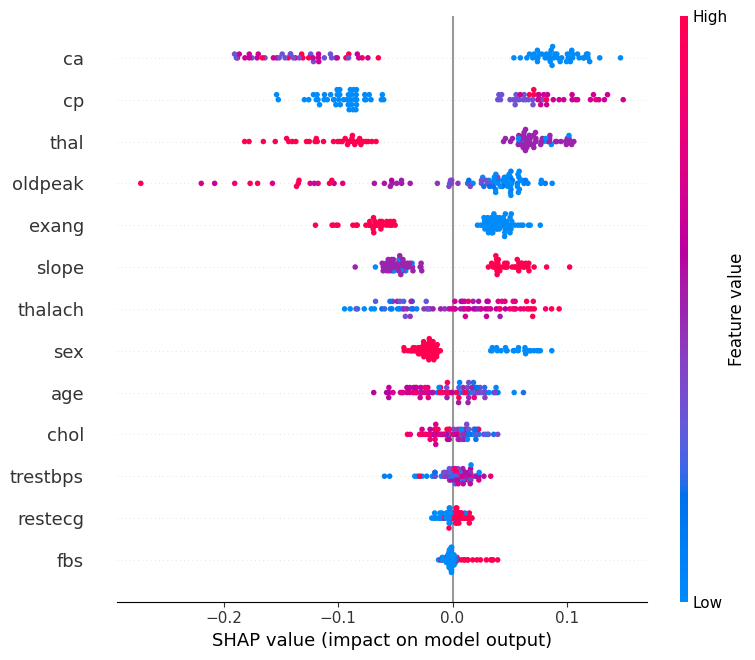

In [31]:
# Model Transparency with SHAP
# =======================
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# SHAP output handling for binary classification (latest versions)
if isinstance(shap_values, list):
    shap_to_plot = shap_values[1]  # old behavior
else:
    # new behavior: (n_samples, n_features, n_classes)
    shap_to_plot = shap_values[:, :, 1]

shap.summary_plot(shap_to_plot, X_test, show=True)

In [32]:
#  Compliance & Audit Documentation
# =======================
compliance_notes = f"""
Model Compliance and Audit Report:
-----------------------------------
Timestamp: {audit_log['timestamp']}
Bias Detection:
Outcome disparities between male and female patients:
{bias_report}

Model Performance:
- Detailed metrics in classification report
- Confusion matrix: {audit_log["confusion_matrix"]}

Transparency:
- SHAP used to interpret feature importance and influence
- Explainability ensures accountability in medical decisions

Governance & Auditing:
- Metrics, bias analysis, and interpretability documented
- Report aligns with AI in healthcare governance frameworks (HIPAA, WHO guidelines)
"""
print(compliance_notes)



Model Compliance and Audit Report:
-----------------------------------
Timestamp: 2025-08-14T08:52:54.178375
Bias Detection:
Outcome disparities between male and female patients:
        total  positive_rate_actual  positive_rate_predicted
sex                                                         
Female     24              0.750000                 0.750000
Male       67              0.477612                 0.477612

Model Performance:
- Detailed metrics in classification report
- Confusion matrix: [[33, 8], [8, 42]]

Transparency:
- SHAP used to interpret feature importance and influence
- Explainability ensures accountability in medical decisions

Governance & Auditing:
- Metrics, bias analysis, and interpretability documented
- Report aligns with AI in healthcare governance frameworks (HIPAA, WHO guidelines)

